# Predicting Traffic Volume on the I-94 in Minnesota, USA

Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The purpose of this notebook is to predict the traffic flow at a particular point of an interstate highway. The data was recorded hourly on highway I-94 between Minneapolis and St. Paul, Minnesota over a six year period. It contains both numerical and categorical features, with a target variable counting the number of cars passing a point each hour. Descriptions and ranges of the features are given below.

1. holiday (categorical) - national and regional holidays: either None or name of holiday
2. temp (numerical continuous) - average temperature over the course of the hour (Kelvin): 0.00 to 310.07
3. rain_1h (numerical continuous) - rain that fell during the hour (mm): 0.0 to 9831.3
4. snow_1h (numerical continuous) - amount of snow accumulated during the hour (mm): 0.0 to 0.51
5. clouds_all (numerical discrete) - percentage of cloud cover (%): 0 to 100
6. weather_main (categorical) - short description of weather for the hour: eg. 'sunny' or 'rainy'
7. weather_description (categorical) - more detailed description of the weather: 7.9 to 860.6
8. date_time (date/time) - the date and time of day the data was measured: 0.0 to 56.10
9. traffic_volume (numerical discrete) - number of cars passing point of interest (target variable): 0 to 7280


## Machine Learning

Methods:
- Split the data into train and test sets in two different ways
    1. Shuffle all the data, and split by a train:test fraction
    2. Leave the data ordered and pull out a single year
    - Since the data corresponds to a time series, it is possible there is some temporal information that can be gleaned by leaving the data in order. Pulling out a contiguous year allows the model to train on data in this way.
- Since the numerical data is not Gaussian distributed, it does not make sense to standardize it, as this would change the distributions (although tree methods such as random forests and XGBoost are agnostic to this). Therefore, the data is only normalized to the range [0, 1]. The target variable is also normalize to this range.
- The models are trained using a randomized parameter search, and the results are compared across the four combinations of data preprocessing:
    1. Shuffled and unnormalized
    2. Unshuffled and unnormalized
    2. Shuffled and normalized
    2. Unshuffled and normalized


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ShuffleSplit, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from my_regression import BinaryEncoder

# Turn off chained assignment warnings
pd.options.mode.chained_assignment = None


In [2]:
# Load the preprocessed data
pp_data = pd.read_csv('data/traffic_volume_preprocessed.csv')
enc_data = pd.read_csv('data/traffic_volume_preprocessed_all_cols.csv')

# Display the data and its summary statistics
display(pp_data.head(n=5))
display(pp_data.describe())


,day_of_year_cos,day_of_year_sin,hour_cos,hour_sin,weather_main_0,weather_main_1,weather_main_2,weather_main_3,weekday,holiday,temp,rain_1h,clouds_all,traffic_volume
0,0.008583,-0.999963,-0.707107,7.071068e-01,0,0,0,1,1,0,288.28,0.0,40,5545
1,0.008583,-0.999963,-0.866025,5.000000e-01,0,0,0,1,1,0,289.36,0.0,75,4516
2,0.008583,-0.999963,-0.965926,2.588190e-01,0,0,0,1,1,0,289.58,0.0,90,4767
3,0.008583,-0.999963,-1.000000,1.224647e-16,0,0,0,1,1,0,290.13,0.0,90,5026
4,0.008583,-0.999963,-0.965926,-2.588190e-01,0,0,0,1,1,0,291.14,0.0,75,4918


,day_of_year_cos,day_of_year_sin,hour_cos,hour_sin,weather_main_0,weather_main_1,weather_main_2,weather_main_3,weekday,holiday,temp,rain_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,4.057500e+04,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,-0.041456,0.009032,6.167561e-03,-0.001929,0.067800,0.212421,0.146716,0.453703,0.714208,0.031349,281.379775,0.033772,44.199162,3290.650474
std,0.715239,0.697609,7.085372e-01,0.705661,0.251406,0.409027,0.353827,0.497858,0.451796,0.174262,13.097795,0.196722,38.683447,1984.772909
min,-1.000000,-0.999991,-1.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,243.390000,0.000000,0.000000,0.000000
25%,-0.762354,-0.668064,-7.071068e-01,-0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,271.840000,0.000000,1.000000,1248.500000
50%,-0.094279,-0.008607,6.123234e-17,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,282.860000,0.000000,40.000000,3427.000000
75%,0.690173,0.705584,7.071068e-01,0.707107,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,292.280000,0.000000,90.000000,4952.000000
max,1.000000,0.999991,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,310.070000,4.036539,100.000000,7280.000000


In [3]:
# Split into train and test sets
X_pd, y_pd = pp_data.iloc[:, :-1], pp_data.iloc[:, -1]

# Split the data by shuffling
tmp_split = train_test_split(X_pd, y_pd, test_size=0.215, random_state=66)
rand_split = [x.reset_index(drop=True) for x in tmp_split]
print(len(rand_split[0]))

# Split the data by extracting a contiguous year for testing
train_inds = enc_data.loc[enc_data.year != 2017].index
test_inds = enc_data.loc[enc_data.year == 2017].index
X_train_year = X_pd.iloc[train_inds].reset_index(drop=True)
X_test_year = X_pd.iloc[test_inds].reset_index(drop=True)
y_train_year = y_pd.iloc[train_inds].reset_index(drop=True)
y_test_year = y_pd.iloc[test_inds].reset_index(drop=True)
print(len(X_train_year))

data_splits = [rand_split, [X_train_year, X_test_year, y_train_year, y_test_year]]


31851
31862


In [4]:
# Normalize the data using the numerical training features
norm_splits = []
X_scalers = []
y_scalers = []
n_enc_col = 10
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    # Extract the numerical data
    X_train_num = X_train.iloc[:, n_enc_col:]
    X_test_num = X_test.iloc[:, n_enc_col:]

    # Normalize the data
    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(X_train_num)
    X_scalers.append(X_scaler)
    X_train_num_norm = X_scaler.transform(X_train_num)
    X_test_num_norm = X_scaler.transform(X_test_num)
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(y_train.values.reshape(-1, 1))
    y_scalers.append(y_scaler)
    y_train_norm = y_scaler.transform(y_train.values.reshape(-1, 1))
    y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))
    
    # Convert normalized data to pd.DataFrames
    X_train_num_norm_pd = pd.DataFrame(X_train_num_norm)
    X_test_num_norm_pd = pd.DataFrame(X_test_num_norm)
    y_train_norm_pd = pd.Series(y_train_norm.squeeze())
    y_test_norm_pd = pd.Series(y_test_norm.squeeze())
    y_train_norm_pd.columns = pp_data.columns[-1:]
    y_test_norm_pd.columns = pp_data.columns[-1:]

    # Recombine with the categorical data
    X_train_norm = pd.concat((X_train.iloc[:, :n_enc_col], X_train_num_norm_pd), axis=1)
    X_test_norm = pd.concat((X_test.iloc[:, :n_enc_col], X_test_num_norm_pd), axis=1)
    X_train_norm.columns = pp_data.columns[:-1]
    X_test_norm.columns = pp_data.columns[:-1]
    # display(X_train_norm.head(n=5))

    # Append the normalized data
    norm_splits.append([X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd])


In [5]:
# Define a grid search to train and test the model
cv_splits = [ShuffleSplit(n_splits=10, test_size=0.2, random_state=66),
             TimeSeriesSplit(n_splits=5)]

# Random forest regressor
d_forest = {'name': 'Random Forest',
           'model': RandomForestRegressor(random_state=66),
           'n_itr': 200,
           'params': {'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
                      'max_features': [1.0, 'sqrt'],
                      'max_depth': [2, 3, 4, 5, 6, 7, 8],
                      'min_samples_split': np.linspace(0.2, 0.9, 8),
                      'min_samples_leaf': [5, 10, 20, 30, 40, 50, 70, 100],
                      'max_leaf_nodes': [100, 80, 60, 40, 20, 10, 5],
                      'max_samples': np.linspace(0.1, 1., 10),
                      'ccp_alpha': np.linspace(0, 0.05, 11)}}

# SVR
d_svr = {'name': 'SVR',
         'model': SVR(kernel='rbf'),
         'n_itr': 10,
         'params': {'gamma': ['scale', 'auto'],
                    'C': [10, 50, 100],
                    'epsilon': [0.1, 0.2, 0.4, 0.6]}}

# XGBoost
d_xgb = {'name': 'XGBoost',
         'model': XGBRegressor(),
         'n_itr': 100,
         'params': {'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
                    'learning_rate': np.linspace(0., 0.9, 10),
                    'subsample': np.linspace(0.1, 1., 10),
                    'min_child_weight': [0.1, 1, 5, 10, 20, 50],
                    'max_leaves': [5, 10, 20, 40, 70, 100],
                    'max_depth': np.arange(1, 12),
                    'gamma': [1, 2, 4, 7, 10, 15, 20, 25]}}

# Assign the models to a dictionary
models = {'forest': d_forest.copy(),
          'svr': d_svr.copy(),
          'xgb': d_xgb.copy()}


In [6]:
# Find the best models
t_start = time()
for model in models.values():
    print(model['name'])
    
    # Select a model using both shuffled and contiguous data
    split_search = []
    split_train_scores = []
    for X_train, X_test, y_train, y_test in data_splits:
        
        # Select a model using multiple cross-validation schemes
        cv_search = []
        cv_train_scores = []
        for cv_split in cv_splits:
            
            # Initialize a random parameter search
            n_itr = model['n_itr']
            param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)
        
            # Find the best model
            t_run0 = time()
            param_search.fit(X_train, y_train)
            t_run = time() - t_run0
            print(f'Took {timedelta(seconds=t_run)} to run the grid search')

            # Save the cross-validation results
            cv_search.append(param_search)
            cv_train_scores.append(param_search.best_score_)

        # Save the data split results
        split_search.append(cv_search)
        split_train_scores.append(cv_train_scores)

    # Update the dictionary
    model['model_search'] = split_search
    model['best_train_r2'] = split_train_scores
    model['training_tree'] = [['Shuffled Data', 'Contiguous Data'],
                              ['Shuffle Split Cross-validation',
                               'Time Series Cross-validation']]
    print()

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Random Forest
Took 0:03:53.069888 to run the grid search
Took 0:01:36.714834 to run the grid search
Took 0:04:04.551309 to run the grid search
Took 0:01:38.108374 to run the grid search

SVR
Took 0:13:07.579468 to run the grid search
Took 0:03:49.558793 to run the grid search
Took 0:12:51.664753 to run the grid search
Took 0:03:53.373017 to run the grid search

XGBoost
Took 0:17:09.599991 to run the grid search
Took 0:04:44.269274 to run the grid search
Took 0:14:02.449643 to run the grid search
Took 0:04:08.266711 to run the grid search

Took 1:24:59.208146 to run all grid searches


In [7]:
# Find the best models
t_start = time()
for model in models.values():
    print(model['name'])
    
    # Select a model using both shuffled and contiguous data
    split_search = []
    split_train_scores = []
    for X_train, X_test, y_train, y_test in norm_splits:
        
        # Select a model using multiple cross-validation schemes
        cv_search = []
        cv_train_scores = []
        for cv_split in cv_splits:
            
            # Initialize a random parameter search
            n_itr = model['n_itr']
            param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)
        
            # Find the best model
            t_run0 = time()
            param_search.fit(X_train, y_train)
            t_run = time() - t_run0
            print(f'Took {timedelta(seconds=t_run)} to run the grid search')

            # Save the cross-validation results
            cv_search.append(param_search)
            cv_train_scores.append(param_search.best_score_)

        # Save the data split results
        split_search.append(cv_search)
        split_train_scores.append(cv_train_scores)

    # Update the dictionary
    model['model_search_norm'] = split_search
    model['best_train_r2_norm'] = split_train_scores
    print()

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Random Forest
Took 0:04:26.481239 to run the grid search
Took 0:01:31.513629 to run the grid search
Took 0:04:25.926574 to run the grid search
Took 0:01:34.932260 to run the grid search

SVR
Took 0:03:18.974507 to run the grid search
Took 0:02:03.549204 to run the grid search
Took 0:02:01.136420 to run the grid search
Took 0:01:07.565995 to run the grid search

XGBoost
Took 0:18:58.575362 to run the grid search
Took 0:04:53.881631 to run the grid search
Took 0:15:15.555782 to run the grid search
Took 0:05:24.221226 to run the grid search

Took 1:05:02.315015 to run all grid searches


Random Forest
[[0.8157937700083471, 0.8155172991464184], [0.8240964429669612, 0.824118864979472]]
[[0.6192647837356766, 0.6191976183627779], [0.8009536962182373, 0.8158626202324122]]
SVR
[[0.6256148352586153, 0.6256194816346135], [0.653957133669535, 0.653957133669535]]
[[0.9363597133554324, 0.9363597133554324], [0.9298136839573804, 0.9366504646819533]]
XGBoost
[[0.9708696681175807, 0.9674985108814684], [0.9458112395231981, 0.9556057680458754]]
[[0.9442741837027198, 0.9474135183132741], [0.9543880453540337, 0.9515782970269535]]


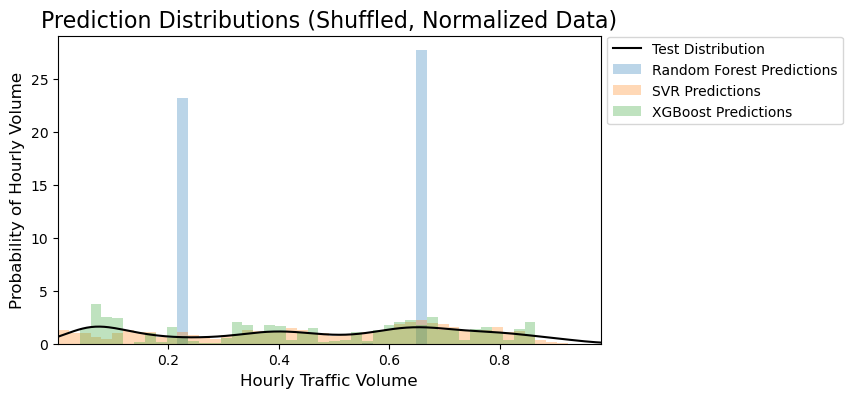

In [35]:
# Check the performance of the models on the test data
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for m, model in enumerate(models.values()):
    if model['name'] not in ['Random Forest', 'SVR', 'XGBoost']:
        continue
    print(model['name'])
    model_searches = model['model_search']
    model_searches_norm = model['model_search_norm']
    split_test_scores = []
    split_norm_test_scores = []
    for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
        X_norm_train, X_norm_test, y_train_norm, y_test_norm = norm_splits[i]
        cv_test_scores = []
        cv_norm_test_scores = []
        for j in range(len(cv_splits)):
            # Model trained on unnormalized data
            best_model = model_searches[i][j].best_estimator_
            y_pred = best_model.predict(X_test)
            cv_test_scores.append(r2_score(y_test, y_pred))

            # Model trained on normalized data
            best_norm_model = model_searches_norm[i][j].best_estimator_
            y_pred_norm = best_norm_model.predict(X_norm_test)
            cv_norm_test_scores.append(r2_score(y_test_norm, y_pred_norm))
            
            # Plot the predicted distribution
            if (i == 0) and (j == 0):
                _, bins = np.histogram(y_test_norm, bins=50)
                if m == 0:
                    y_test_norm.plot.kde(ind=500, color='k', ax=ax, label='Test Distribution')
                # y_pred_plt = pd.Series(y_pred)
                y_pred_plt = pd.Series(y_pred_norm)
                ax.hist(y_pred_plt, bins, color=f'C{m}', histtype='bar', density=True, alpha=0.3, label=model['name'] + ' Predictions')
                ax.set_title('Prediction Distributions (Shuffled, Normalized Data)', fontsize=16)
                ax.set_xlim([bins[0], bins[-1]])
                ax.set_ylabel('Probability of Hourly Volume', fontsize=12)
                ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
        
        # Save the data split results
        split_test_scores.append(cv_test_scores)
        split_norm_test_scores.append(cv_norm_test_scores)

    # Update the dictionary
    model['best_test_r2'] = split_test_scores
    model['best_test_r2_norm'] = split_norm_test_scores
    print(split_test_scores)
    print(split_norm_test_scores)

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


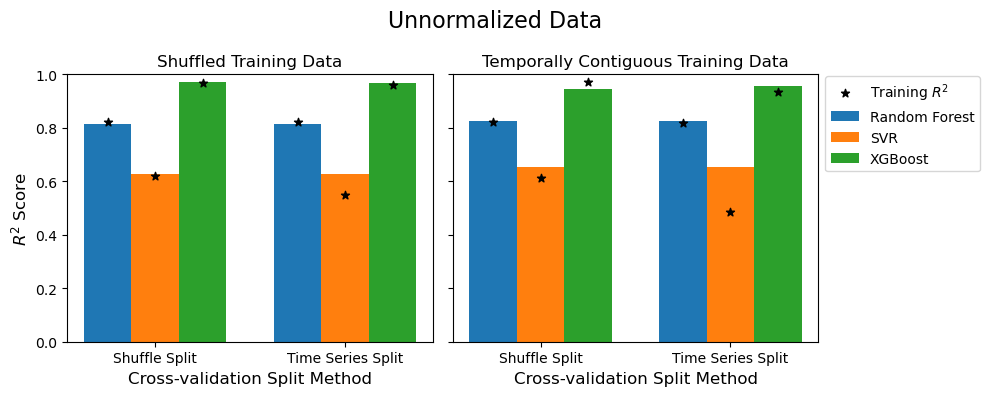

In [9]:
# Compare the models using shuffled and unshuffled data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / (len(models) + 1)
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
for i, model in enumerate(models.values()):
    train_scores = model['best_train_r2']
    test_scores = model['best_test_r2']
    m_name = model['name']
    x_pos = np.arange(len(train_scores)) + i * width
    for j, train_score in enumerate(train_scores):
        axes[j].bar(x_pos, test_scores[j], width=width, label=m_name)
        if i == 2:
            axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
        else:
            axes[j].scatter(x_pos, train_score, c='k', marker='*')
        axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
        axes[j].set_title(plt_ttls[j], fontsize=12)
        axes[j].set_xticks(np.arange(len(train_scores)) + width)
        axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        axes[j].set_ylim([0, 1])
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Unnormalized Data', fontsize=16)
fig.tight_layout()
plt.show()


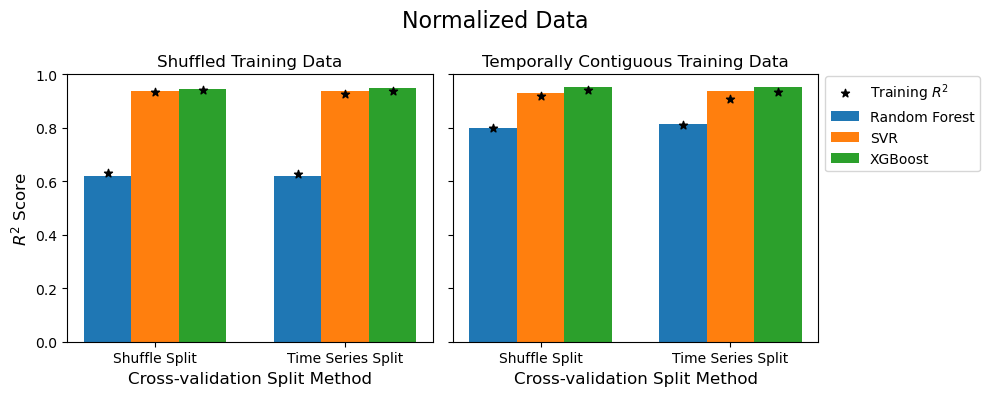

In [10]:
# Compare the models using normalized and unnormalized data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / (len(models) + 1)
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
for i, model in enumerate(models.values()):
    train_scores = model['best_train_r2_norm']
    test_scores = model['best_test_r2_norm']
    m_name = model['name']
    x_pos = np.arange(len(train_scores)) + i * width
    for j, train_score in enumerate(train_scores):
        axes[j].bar(x_pos, test_scores[j], width=width, label=m_name)
        if i == 2:
            axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
        else:
            axes[j].scatter(x_pos, train_score, c='k', marker='*')
        axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
        axes[j].set_title(plt_ttls[j], fontsize=12)
        axes[j].set_xticks(np.arange(len(train_scores)) + width)
        axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        axes[j].set_ylim([0, 1])
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Normalized Data', fontsize=16)
fig.tight_layout()
plt.show()


## Potential Model Improvements

- Check effects of using categorical values with random forest regressor (tree models are supposed to be able to handle categorical features).
- Check effects of splitting data along identifiable features (here: day/night) and training separate models for each.


In [11]:
# Check the effects of categories on the random forest regressor
cat_tree = d_forest.copy()
cat_tree['name'] = 'Random Forest Categories'

# Create a categorized dataset for the tree regressor
label_encoder = LabelEncoder()
enc_weather = label_encoder.fit_transform(enc_data.weather_main)
tree_data = enc_data.iloc[:, 8:].drop(columns=['date_time', 'day_of_week', 'year'])
# tree_data = enc_data.iloc[:, :8].drop(columns=['date_time', 'day_of_week', 'year', 'rain_1h'])
tree_data['rain_1h'] = np.log(tree_data['rain_1h'] + 1)
tree_cols = tree_data.columns.tolist()
tree_cols = tree_cols[-2:] + tree_cols[:-2]
tree_data = tree_data[tree_cols]
tree_data.weather_main = enc_weather
# display(tree_data.head(n=5))

# Split the data into training and test sets
X_tree_pd = tree_data.iloc[:, :-1]
X_train_tree = X_tree_pd.iloc[train_inds].reset_index(drop=True)
X_test_tree = X_tree_pd.iloc[test_inds].reset_index(drop=True)
tree_split = train_test_split(X_tree_pd, y_pd, test_size=0.215, random_state=66)
rand_tree_split = [x.reset_index(drop=True) for x in tree_split]
data_splits_tree = [rand_tree_split, [X_train_tree, X_test_tree, y_train_year, y_test_year]]

# Select a model using both shuffled and contiguous data
split_search = []
split_train_scores = []
split_test_scores = []
t_start = time()
for X_train, X_test, y_train, y_test in data_splits_tree:
    # Select a model using multiple cross-validation schemes
    cv_search = []
    cv_train_scores = []
    cv_test_scores = []
    for cv_split in cv_splits:
        # Initialize a grid
        n_itr = cat_tree['n_itr']
        param_search = RandomizedSearchCV(cat_tree['model'], cat_tree['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)

        # Find the best model
        t_run0 = time()
        param_search.fit(X_train, y_train)
        t_run = time() - t_run0
        print(f'Took {timedelta(seconds=t_run)} to run the grid search')

        # Save the results
        cv_search.append(param_search)
        cv_train_scores.append(param_search.best_score_)

        # Check the performance of the models on the test data
        best_model = param_search.best_estimator_
        y_pred = best_model.predict(X_test)
        cv_test_scores.append(r2_score(y_test, y_pred))
        print(param_search.best_params_)

    split_search.append(cv_search)
    split_train_scores.append(cv_train_scores)
    split_test_scores.append(cv_test_scores)

# Update the dictionary
cat_tree['model_search'] = split_search
cat_tree['best_train_r2'] = split_train_scores
cat_tree['best_test_r2'] = split_test_scores
cat_tree['training_tree'] = [['Shuffled Data', 'Contiguous Data'],
                            ['Shuffle Split Cross-validation',
                             'Time Series Cross-validation']]
print('Training scores: ', split_train_scores)
print('Testing scores: ', split_test_scores)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')

# Add model to the dictionary
models['cat_tree'] = cat_tree


Took 0:03:55.775151 to run the grid search
{'n_estimators': 200, 'min_samples_split': 0.2, 'min_samples_leaf': 10, 'max_samples': 1.0, 'max_leaf_nodes': 40, 'max_features': 1.0, 'max_depth': 5, 'ccp_alpha': 0.005}
Took 0:01:34.414420 to run the grid search
{'n_estimators': 50, 'min_samples_split': 0.2, 'min_samples_leaf': 70, 'max_samples': 0.9, 'max_leaf_nodes': 5, 'max_features': 1.0, 'max_depth': 8, 'ccp_alpha': 0.005}
Took 0:04:56.178274 to run the grid search
{'n_estimators': 500, 'min_samples_split': 0.2, 'min_samples_leaf': 20, 'max_samples': 0.7000000000000001, 'max_leaf_nodes': 100, 'max_features': 1.0, 'max_depth': 7, 'ccp_alpha': 0.04}
Took 0:01:34.362676 to run the grid search
{'n_estimators': 50, 'min_samples_split': 0.2, 'min_samples_leaf': 30, 'max_samples': 0.7000000000000001, 'max_leaf_nodes': 20, 'max_features': 1.0, 'max_depth': 4, 'ccp_alpha': 0.005}
Training scores:  [[0.8116629293986733, 0.8024467208430929], [0.7889933206310712, 0.7885747522694226]]
Testing scores

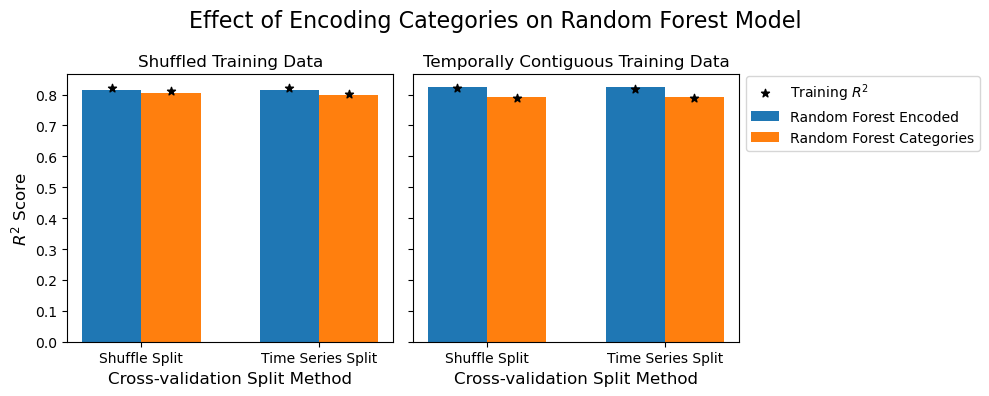

In [12]:
# Compare the models using shuffled and unshuffled data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / 3
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
bar_names = ['Random Forest Encoded', 'Random Forest Categories']
cnt = 0
for key, model in models.items():
    if key in ['forest', 'cat_tree']:
        train_scores = model['best_train_r2']
        test_scores = model['best_test_r2']
        x_pos = np.arange(len(train_scores)) + cnt * width
        for j, train_score in enumerate(train_scores):
            axes[j].bar(x_pos, test_scores[j], width=width, label=bar_names[cnt])
            if cnt == 0:
                axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
            else:
                axes[j].scatter(x_pos, train_score, c='k', marker='*')
            axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
            axes[j].set_title(plt_ttls[j], fontsize=12)
            axes[j].set_xticks(np.arange(len(train_scores)) + width / 2)
            axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        cnt += 1
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Effect of Encoding Categories on Random Forest Model', fontsize=16)
fig.tight_layout()
plt.show()


In [13]:
# Separate the day and night data to improve model
day_mask = (enc_data.hour > 4) & (enc_data.hour < 23)
day_data = pp_data.loc[day_mask]
night_data = pp_data.loc[~day_mask]

# Split into training and test sets
X_day_pd, y_day_pd = day_data.iloc[:, :-1], day_data.iloc[:, -1]
X_night_pd, y_night_pd = night_data.iloc[:, :-1], night_data.iloc[:, -1]

# Split the data by shuffling
tmp_split = train_test_split(X_day_pd, y_day_pd, test_size=0.215, random_state=66)
day_split = [x.reset_index(drop=True) for x in tmp_split]
tmp_split = train_test_split(X_night_pd, y_night_pd, test_size=0.215, random_state=66)
night_split = [x.reset_index(drop=True) for x in tmp_split]
day_night_data = [day_split, night_split]

# Normalize the data using the numerical training features
# day_night_norm = []
day_night_X_scalers = []
day_night_y_scalers = []
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    # Extract the numerical data
    X_train_num = X_train.iloc[:, n_enc_col:]
    X_test_num = X_test.iloc[:, n_enc_col:]

    # Normalize the data
    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(X_train_num)
    day_night_X_scalers.append(X_scaler)
    X_train_num_norm = X_scaler.transform(X_train_num)
    X_test_num_norm = X_scaler.transform(X_test_num)
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(y_train.values.reshape(-1, 1))
    day_night_y_scalers.append(y_scaler)
    y_train_norm = y_scaler.transform(y_train.values.reshape(-1, 1))
    y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Convert normalized data to pd.DataFrames
    X_train_num_norm_pd = pd.DataFrame(X_train_num_norm)
    X_test_num_norm_pd = pd.DataFrame(X_test_num_norm)
    y_train_norm_pd = pd.Series(y_train_norm.squeeze())
    y_test_norm_pd = pd.Series(y_test_norm.squeeze())
    y_train_norm_pd.columns = pp_data.columns[-1:]
    y_test_norm_pd.columns = pp_data.columns[-1:]

    # Recombine with the categorical data
    X_train_norm = pd.concat((X_train.iloc[:, :n_enc_col], X_train_num_norm_pd), axis=1)
    X_test_norm = pd.concat((X_test.iloc[:, :n_enc_col], X_test_num_norm_pd), axis=1)
    X_train_norm.columns = pp_data.columns[:-1]
    X_test_norm.columns = pp_data.columns[:-1]

    # Append the normalized data
    # day_night_norm.append([X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd])
    day_night_data[i] = [X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd]


In [14]:
# Fit the day and night models using a grid search
day_night_models = []
day_night_names = ['Day', 'Night']
day_night_test_pred = []
day_night_test_yt = []
day_night_split = cv_splits[0]
t_start = time()
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    # Initialize a model and grid search
    print(f'{day_night_names[i]} Model')
    model = d_xgb.copy()
    # cv_split = cv_splits[0]
    n_itr = model['n_itr']
    param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=day_night_split)

    # Find the best model
    t_run0 = time()
    param_search.fit(X_train, y_train)
    t_run = time() - t_run0
    print(f'Took {timedelta(seconds=t_run)} to run the grid search')

    # Save the results
    model['name'] = f'XGBoost {day_night_names[i]}'
    model['model_search'] = param_search
    model['best_train_r2'] = param_search.best_score_
    print(param_search.best_params_)
    
    # Calculate the performance
    y_pred = param_search.best_estimator_.predict(X_test)
    model['best_test_r2'] = r2_score(y_test, y_pred)
    day_night_models.append(model)

    # Calculate a combined y_pred to find the combined R2
    day_night_test_pred.append(y_pred)
    day_night_test_yt.append(y_test)
    
    # Add model to the dictionary
    models[f'{day_night_names[i]}_xgb'] = model
    
# Combined day and night R2 score
day_night_test_r2 = r2_score(np.hstack(day_night_test_yt), np.hstack(day_night_test_pred))

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Day Model
Took 0:13:05.004186 to run the grid search
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 20, 'max_leaves': 100, 'max_depth': 9, 'learning_rate': 0.6000000000000001, 'gamma': 1}
Night Model
Took 0:03:59.229733 to run the grid search
{'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 20, 'max_leaves': 10, 'max_depth': 4, 'learning_rate': 0.9, 'gamma': 1}
Took 0:17:04.241480 to run all grid searches


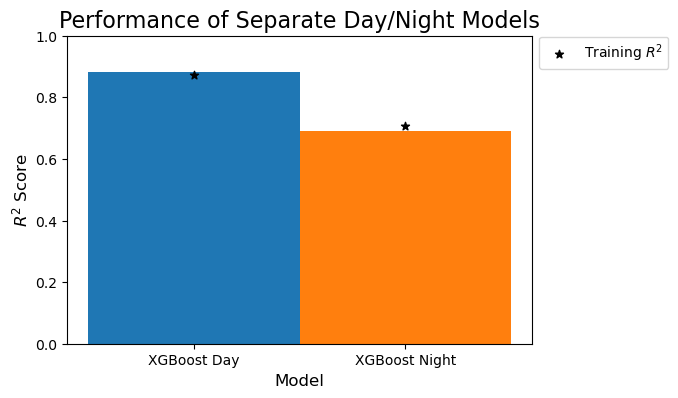

In [15]:
# Compare the day and night models
fig, ax = plt.subplots(1, figsize=(6, 4), sharey=True)
width = 1 / 3
m_names = []
for i, model in enumerate(day_night_models):
    train_score = model['best_train_r2']
    test_score = model['best_test_r2']
    m_name = model['name']
    m_names.append(model['name'])
    x_pos = i * width
    ax.bar(x_pos, test_score, width=width)
    if i == 1:
        ax.scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
    else:
        ax.scatter(x_pos, train_score, c='k', marker='*')
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Performance of Separate Day/Night Models', fontsize=16)
ax.set_xticks([0, width])
ax.set_xticklabels(m_names)
ax.set_ylabel(r'$R^2$' + ' Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


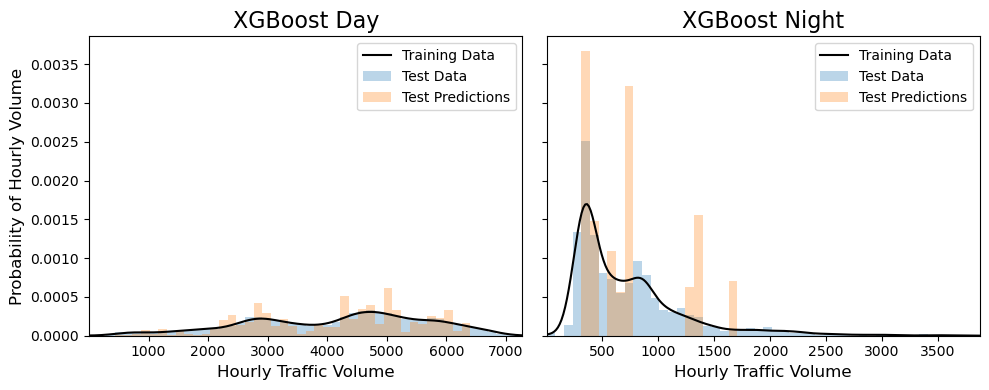

In [16]:
# Plot the distributions of the day and night test data and results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    # Calculate and scale the target variable
    y_scaler = day_night_y_scalers[i]
    model = day_night_models[i]
    best_model = model['model_search'].best_estimator_
    y_pred = y_scaler.inverse_transform(best_model.predict(X_test).reshape(-1, 1))
    y_train = pd.Series(y_scaler.inverse_transform(y_train.values.reshape(-1, 1)).squeeze())
    y_test = pd.Series(y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).squeeze())
    
    # Plot the distributions
    _, bins = np.histogram(y_test, bins=50)
    y_train.plot.kde(ind=500, color='k', ax=axes[i], label='Training Data')
    axes[i].hist(y_test, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
    axes[i].hist(y_pred, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
    
    # Set the plot parameters
    axes[i].set_title(model['name'], fontsize=16)
    axes[i].set_xlim([bins[0], bins[-1]])
    axes[i].legend()
    axes[i].set_xlabel('Hourly Traffic Volume', fontsize=12)
axes[0].set_ylabel('Probability of Hourly Volume', fontsize=12)
fig.tight_layout()
plt.show()


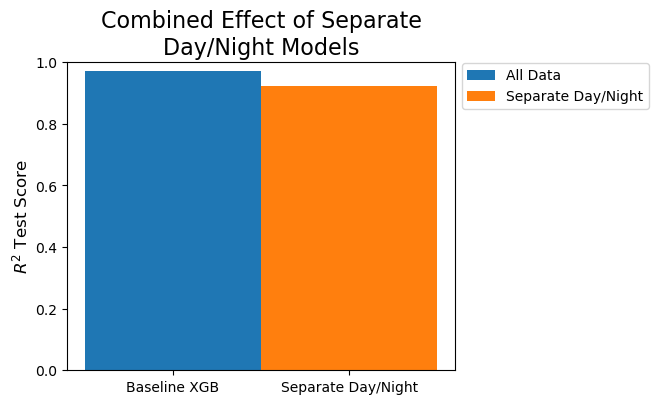

In [17]:
# Compare the day/night model performance to the baseline
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
width = 1 / 3
for i, model in enumerate(models.values()):
    if model['name'] == 'XGBoost':
        test_scores = model['best_test_r2']
        ax.bar(0, test_scores[0][0], width=width, label='All Data')
ax.bar(width, day_night_test_r2, width=width, label='Separate Day/Night')
ax.set_xticks([0, width])
ax.set_xticklabels(['Baseline XGB', 'Separate Day/Night'])
ax.set_title('Combined Effect of Separate\nDay/Night Models', fontsize=16)
ax.set_ylabel(r'$R^2$' + ' Test Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


In [18]:
# Save the models in a pickle file
with open('models/trained_models.pkl', 'wb') as file:
    pkl.dump(models, file)


## Conclusions and Lessons Learned

- SVM methods don't scale well with large amounts of data (long training and prediction times). This limits the hyperparameter tuning possible (although the SVR model does not have that many hyperparameters anyway).
- Whitening the data (not shown here) ruined the SVR and reduced XGBoost performance. Upon looking into the cause of this, it was discovered that if the original data's distributions are non-Gaussian, then the data should only be normalized and not whitened.
- Although the random forest has a relatively good $R^2$ score (explained variance), you can see from the distribution of predictions that it is probably overfitting, as it is only predicting a small set of traffic flow volumes. Therefore, the overall performance is not actually that good. On the other hand, SVR has a much lower explained variance, but its prediction distributions look more realistic. This is a good reminder that models should be evaluated in more than one way, to determine which one performs best. 
- As expected, the random forest and XGBoost performance scores are not affected by normalization (since these models are agnostic to the underlying distribution of the data). However, SVR's performance is greatly improved with the addition of normalization preprocessing.
- Encoding the categorical features gives a negligible improvement to the random forest model. This may indicate that the model was able to utilize the simply encoded categorial data nearly as well as the encoded features. It is also possible that the categorical features (the weather description in particular) are not important for the predictions. Evidence for the weather category's lack of importance can be found in the EDA.
- Splitting the data into day/night sets and training expert models actually reduces the individual model's predictive ability. This may be because it reduces the amount of training data available, and because XGBoost is already agnostic to the underlying distributions. Perhaps this would have been more effective if tested with a model class that does not handle multimodal target variables well. This will be explored when looking at training a neural network to solve the task. 

Ideas for future improvements and analysis
- Could use unsupervised clustering, such as Guassian mixture modelling or Kernel Density Estimation, to divide the target variable into its modalities, and then train models based on these clusters.
- After performing a randomized grid search to find the range of best parameters, the model could be further improved with hyperparameter tuning using a grid search. 
- Look at effects of removing rain_1h feature (many zero values perhaps act as noise). Must use adjusted-$R^2$ to measure this.
- Perhaps calculating the variance explained by a day/night boolean feature would help explain the results of splitting the model.


## Neural Network Model

This model is implemented to determine whether a simple neural network can achieve performance similar to or better than other machine learning methods, with minimal tuning. It is also meant to help me learn more about what types of problems simple neural networks can be applied to.

In most resources that I found addressing the use of neural networks on multimodal target regression variables, it was suggested that the data be divided into its component modalities. This can either be done as above (finding a natural division in the data such as day/night), or by unsupervised methods such as Gaussian mixture modelling or Kernel estimation. In order to try this, the data is again split into night and day, and two separate models are trained.


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [20]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.length = X.shape[0]

    def __len__(self):
        return self.labels.size

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    
    def __len__(self):
        return self.length


    
# Define the model class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y.squeeze())
        batch_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    return batch_loss



In [21]:
# Define hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 500
loss_fn = nn.MSELoss()


In [22]:
# Define the training and test data loaders
split_ind = 0
X_train_nn_baseline, X_test_nn_baseline, y_train_nn_baseline, y_test_nn_baseline = [x.values for x in norm_splits[split_ind]]
train_data = CustomDataset(X_train_nn_baseline, y_train_nn_baseline)
test_data = CustomDataset(X_test_nn_baseline, y_test_nn_baseline)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
neural_net = NeuralNetwork(X_train.shape[-1], 32, 1).to('cpu')
neural_net = neural_net.float()
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate)


Took 0:02:46.742038 to train the model


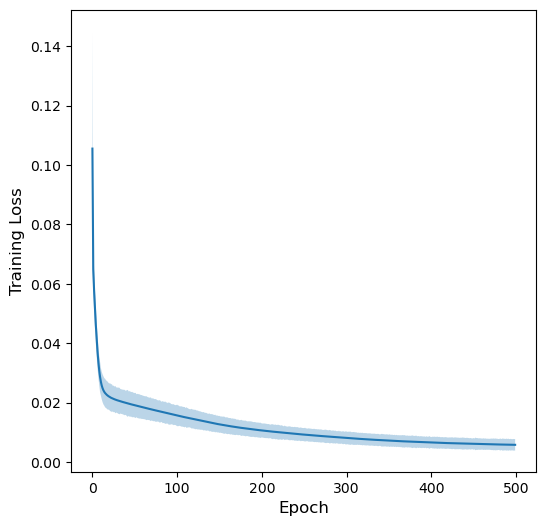

In [23]:
# Train the model
train_loss_avg = np.zeros(epochs)
train_loss_std = np.zeros(epochs)
t_start = time()
for t in range(epochs):
    epoch_loss = train_loop(train_dataloader, neural_net, loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(epochs), train_loss_avg)
ax.fill_between(np.arange(epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


In [24]:
# Print the results
y_train_nn_pred_baseline = neural_net(torch.Tensor(X_train_nn_baseline)).detach().numpy()
y_test_nn_pred_baseline = neural_net(torch.Tensor(X_test_nn_baseline)).detach().numpy()
rmse_train_nn_baseline = mean_squared_error(y_train_nn_baseline, y_train_nn_pred_baseline, squared=False)
rmse_test_nn_baseline = mean_squared_error(y_test_nn_baseline, y_test_nn_pred_baseline, squared=False)
r2_test_nn_baseline = r2_score(y_test_nn_baseline, y_test_nn_pred_baseline)
print(f'Training RMSE on NN model: {rmse_train_nn_baseline:4.3f}')
print(f'Test RMSE on NN model: {rmse_test_nn_baseline:4.3f}')
print(f'Test R^2 on NN model: {r2_test_nn_baseline:4.3f}')


Training RMSE on NN model: 0.076
Test RMSE on NN model: 0.077
Test R^2 on NN model: 0.920


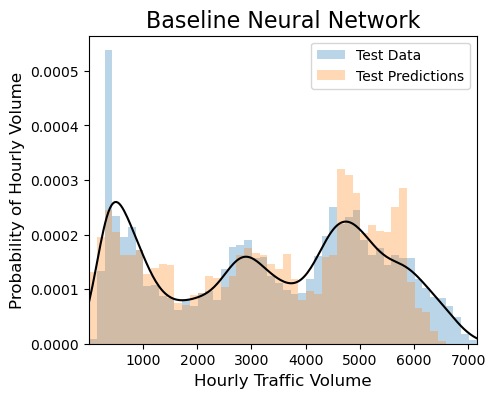

In [25]:
# Plot the distributions of the test data and predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Calculate and scale the target variable
y_scaler = y_scalers[split_ind]
y_pred_hist_baseline = y_scaler.inverse_transform(y_train_nn_pred_baseline)
y_train_hist_baseline = pd.Series(y_scaler.inverse_transform(y_train_nn_baseline.reshape(-1, 1)).squeeze())
y_test_hist_baseline = pd.Series(y_scaler.inverse_transform(y_test_nn_baseline.reshape(-1, 1)).squeeze())

# Plot the distributions
_, bins = np.histogram(y_test_hist_baseline, bins=50)
# ax.hist(y_train_hist_baseline, bins, histtype=u'step', color='k', density=True, label='Training Data')
ax.hist(y_test_hist_baseline, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
ax.hist(y_pred_hist_baseline, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')

# Set the plot parameters
ax.set_title('Baseline Neural Network', fontsize=16)
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
y_train_hist_baseline.plot.kde(ind=500, color='k', ax=ax, label='Training Data')
ax.set_ylabel('Probability of Hourly Volume', fontsize=12)
ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
plt.show()


### Separate Day and Night Models

In [26]:
# Define the training and test data loaders
day_night_arrays = []
day_night_loaders = []
day_night_nets = []
day_night_opti = []
for i, dn_data in enumerate(day_night_data):
    all_arrays = [x.values for x in dn_data]
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = all_arrays
    day_night_arrays.append(all_arrays)
    train_data = CustomDataset(X_train_nn, y_train_nn)
    test_data = CustomDataset(X_test_nn, y_test_nn)
    dn_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dn_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    day_night_loaders.append((dn_train_dataloader, dn_test_dataloader))

    # Initialize a model and optimizer
    net = NeuralNetwork(X_train_nn.shape[-1], 32, 1).to('cpu')
    net = net.float()
    day_night_nets.append(net)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate)
    day_night_opti.append(optimizer)


Day Model
Took 0:02:04.647282 to train the model
Training RMSE on NN model: 0.090
Test RMSE on NN model: 0.089
Test R^2 on NN model: 0.809

Night Model
Took 0:00:42.147112 to train the model
Training RMSE on NN model: 0.091
Test RMSE on NN model: 0.092
Test R^2 on NN model: 0.447



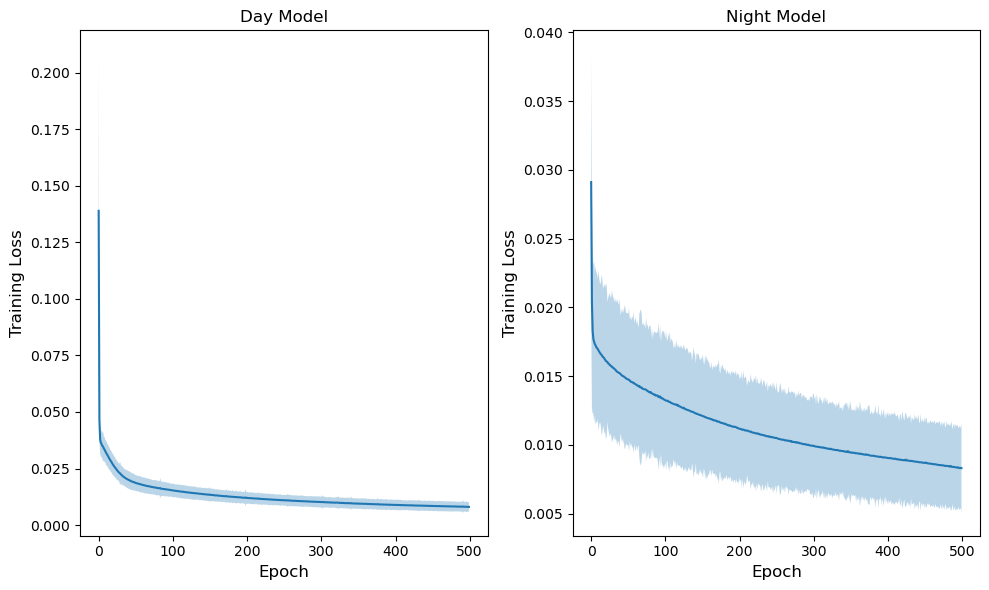

In [27]:
# Train the day/night models
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for i, (train_loader, test_loader) in enumerate(day_night_loaders):
    print(f'{day_night_names[i]} Model')
    train_loss_avg = np.zeros(epochs)
    train_loss_std = np.zeros(epochs)
    t_start = time()
    for t in range(epochs):
        epoch_loss = train_loop(train_loader, day_night_nets[i], loss_fn, day_night_opti[i])
        train_loss_avg[t] = np.mean(epoch_loss)
        train_loss_std[t] = np.std(epoch_loss)

    # Plot the progression of loss and accuracy
    axes[i].plot(np.arange(epochs), train_loss_avg)
    axes[i].fill_between(np.arange(epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
    axes[i].set_xlabel('Epoch', fontsize=12)
    axes[i].set_ylabel('Training Loss', fontsize=12)
    axes[i].set_title(f'{day_night_names[i]} Model', fontsize=12)

    # Print the time taken
    t_full = time() - t_start
    print(f'Took {timedelta(seconds=t_full)} to train the model')

    # Print the results
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = day_night_arrays[i]
    y_train_nn_pred = day_night_nets[i](torch.Tensor(X_train_nn)).detach().numpy()
    y_test_nn_pred = day_night_nets[i](torch.Tensor(X_test_nn)).detach().numpy()
    rmse_train_nn = mean_squared_error(y_train_nn, y_train_nn_pred, squared=False)
    rmse_test_nn = mean_squared_error(y_test_nn, y_test_nn_pred, squared=False)
    r2_test_nn = r2_score(y_test_nn, y_test_nn_pred)
    print(f'Training RMSE on NN model: {rmse_train_nn:4.3f}')
    print(f'Test RMSE on NN model: {rmse_test_nn:4.3f}')
    print(f'Test R^2 on NN model: {r2_test_nn:4.3f}')
    print()

fig.tight_layout()
plt.show()


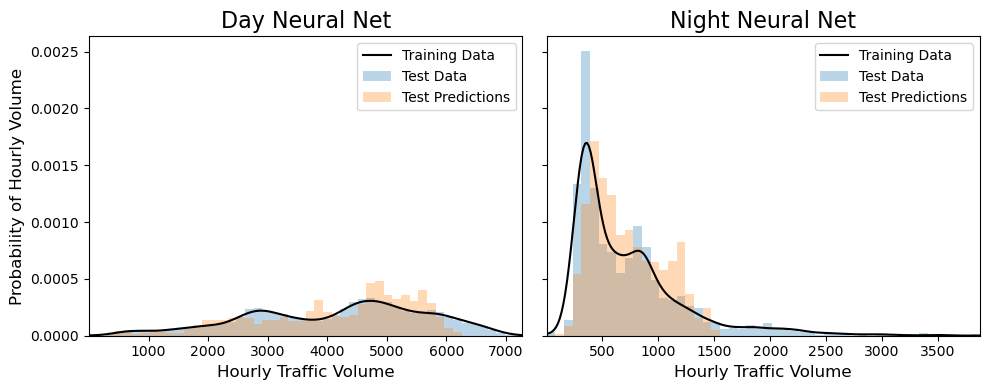

In [28]:
# Plot the distributions of the day and night test data and predictions
day_night_net_train_scores = []
day_night_net_test_scores = []
day_night_test_pred = []
day_night_test_yt = []
day_night_train_yt = []
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, (X_train_nn, X_test_nn, y_train_nn, y_test_nn) in enumerate(day_night_arrays):
    # Calculate and scale the target variable
    y_scaler = day_night_y_scalers[i]
    nn_model = day_night_nets[i]
    y_train_nn_pred = y_scaler.inverse_transform(day_night_nets[i](torch.Tensor(X_train_nn)).detach().numpy().reshape(-1, 1)).squeeze()
    y_test_nn_pred = y_scaler.inverse_transform(day_night_nets[i](torch.Tensor(X_test_nn)).detach().numpy().reshape(-1, 1)).squeeze()
    y_train_nn = pd.Series(y_scaler.inverse_transform(y_train_nn.reshape(-1, 1)).squeeze())
    y_test_nn = pd.Series(y_scaler.inverse_transform(y_test_nn.reshape(-1, 1)).squeeze())
    
    # Calculate the separate day/night training and test scores
    day_night_net_train_scores.append(r2_score(y_train_nn, y_train_nn_pred))
    day_night_net_test_scores.append(r2_score(y_test_nn, y_test_nn_pred))
    
    # Calculate a combined y_pred to find the combined R2
    day_night_test_pred.append(y_test_nn_pred)
    day_night_test_yt.append(y_test_nn)
    day_night_train_yt.append(y_train_nn)
        
    # Plot the prediction distributions
    _, bins = np.histogram(y_test_nn, bins=50)
    y_train_nn.plot.kde(ind=500, color='k', ax=axes[i], label='Training Data')
    # axes[i].hist(y_train_nn, bins, histtype=u'step', color='k', density=True, label='Training Data')
    axes[i].hist(y_test_nn, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
    axes[i].hist(y_test_nn_pred, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
    axes[i].set_title(f'{day_night_names[i]} Neural Net', fontsize=16)
    axes[i].set_xlim([bins[0], bins[-1]])
    axes[i].legend()
    axes[i].set_xlabel('Hourly Traffic Volume', fontsize=12)
axes[0].set_ylabel('Probability of Hourly Volume', fontsize=12)
fig.tight_layout()
plt.show()


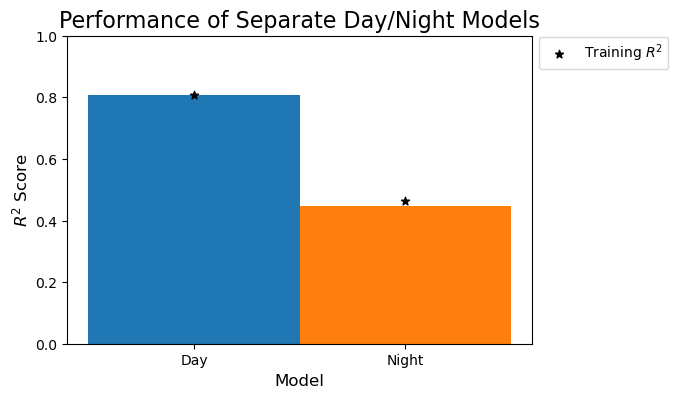

In [29]:
# Compare the day and night models
fig, ax = plt.subplots(1, figsize=(6, 4), sharey=True)
width = 1 / 3
for i, train_score in enumerate(day_night_net_train_scores):
    test_score = day_night_net_test_scores[i]
    x_pos = i * width
    ax.bar(x_pos, test_score, width=width)
    if i == 1:
        ax.scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
    else:
        ax.scatter(x_pos, train_score, c='k', marker='*')
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Performance of Separate Day/Night Models', fontsize=16)
ax.set_xticks([0, width])
ax.set_xticklabels(day_night_names)
ax.set_ylabel(r'$R^2$' + ' Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


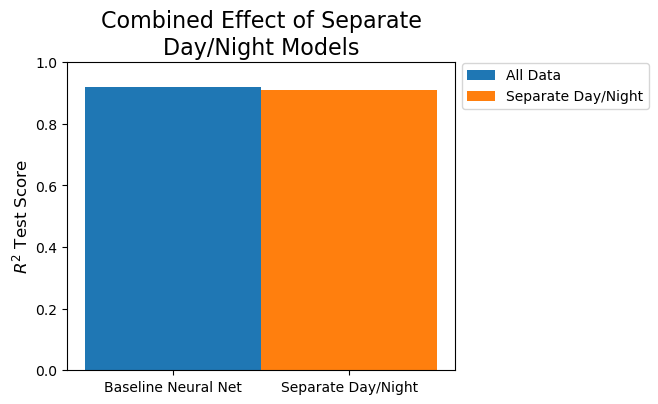

In [30]:
# Compare the day/night model performance to the baseline
day_night_test_r2_nn = r2_score(np.hstack(day_night_test_yt), np.hstack(day_night_test_pred))
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
width = 1 / 3
ax.bar(0, r2_test_nn_baseline, width=width, label='All Data')
ax.bar(width, day_night_test_r2_nn, width=width, label='Separate Day/Night')
ax.set_xticks([0, width])
ax.set_xticklabels(['Baseline Neural Net', 'Separate Day/Night'])
ax.set_title('Combined Effect of Separate\nDay/Night Models', fontsize=16)
ax.set_ylabel(r'$R^2$' + ' Test Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


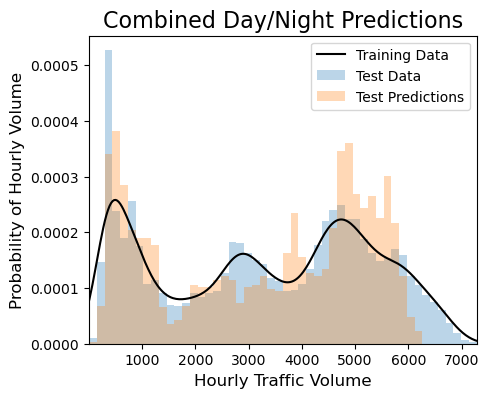

In [31]:
# Combine and scale the day and night data (test and prediction)
day_night_test_pred_combined = pd.Series(np.hstack(day_night_test_pred))
day_night_test_yt_combined = pd.Series(np.hstack(day_night_test_yt))
day_night_train_yt_combined = pd.Series(np.hstack(day_night_train_yt))
_, bins = np.histogram(day_night_test_yt_combined, bins=50)

# Plot the distributions of the combined day/night test data and predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
day_night_train_yt_combined.plot.kde(ind=500, color='k', ax=ax, label='Training Data')
ax.hist(day_night_test_yt_combined, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
ax.hist(day_night_test_pred_combined, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
ax.set_title('Combined Day/Night Predictions', fontsize=16)
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Probability of Hourly Volume', fontsize=12)
ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
plt.show()


## Conclusions and Lessons Learned

- The neural network model performed nearly as well as the XGBoost model, with minimal parameter tuning. It is a little surprising how well it worked, since I was under the impression that neural networks do not handle multimodal targets well. 
- The individual day/night models evaluate similarly to those of the XGBoost model. I find it odd that the $R^2$ scores are quite low for the individual models, but if I simply take the output and prediction vectors and concatenate them, then recalculate the combined $R^2$ score, the result is a much better score. I think that there is either some error in how I am performing the calculations, or something I don't understand about $R^2$. It seems like the individual $R^2$ scores somehow take into account the missing data, although I'm not sure how this is possible. I will have to look at the math to figure this out.
- There is little difference in performance between the combined day/night models and the baseline neural network (which incorporates all the data simultaneously).
